## Visualize signature scores and performance metrics

Gregory Way, 2021

Visualizing the results of the bortezomib signature to distinguish resistant and sensitive clones.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(gridExtra))

source(file.path("utils", "viz.R"))

In [2]:
seed <- 1234
set.seed(seed)

In [3]:
# Set constants
dataset <- "bortezomib"
sig_dir <- file.path("results", "singscore")
perf_dir <- file.path("results", "performance")

sig_results_file <- file.path(sig_dir, paste0("singscore_results", dataset, ".tsv.gz"))
roc_auc_file <- file.path(perf_dir, paste0(dataset, "_roc_auc.tsv"))
roc_curve_file <- file.path(perf_dir, paste0(dataset, "_roc_curve.tsv"))

output_figure_dir <- file.path("figures", "singscore")

main_clones <- c(
    "BZ001",
    "BZ002",
    "BZ003",
    "BZ004", 
    "BZ005",
    "WT clone 01",
    "WT clone 02",
    "WT clone 03",
    "WT clone 04",
    "WT clone 05"
)

main_model_splits <- c("training", "validation", "test", "holdout")

## Load Data

In [4]:
# Load raw signature results
sig_cols <- readr::cols(
    .default = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_integer(),
    Metadata_celltype_shorthand_from_plate_graph = readr::col_integer(),
    Metadata_date = readr::col_integer(),
    Metadata_treatment_shorthand_from_plate_graph = readr::col_integer(),
    TotalScore = readr::col_double(),
    TotalDispersion = readr::col_double(),
    UpScore = readr::col_double(),
    UpDispersion = readr::col_double(),
    DownScore = readr::col_double(),
    DownDispersion = readr::col_double(),
    Metadata_permuted_p_value = readr::col_double(),
    min_permuted_value = readr::col_double(),
    max_permuted_value = readr::col_double()
)

inference_df <- readr::read_tsv(sig_results_file, col_types = sig_cols) %>%
    dplyr::filter(Metadata_model_split == "inference")

signature_df <- readr::read_tsv(sig_results_file, col_types = sig_cols) %>%
    dplyr::filter(Metadata_model_split != "inference")

print(dim(signature_df))
head(signature_df, 4)

[1] 420  28


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,⋯,TotalScore,TotalDispersion,UpScore,UpDispersion,DownScore,DownDispersion,Metadata_permuted_p_value,dataset,min_permuted_value,max_permuted_value
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
219907,B02,2021_03_03_Batch12,6139,2.5x10^3 cells/well,1,WT_parental,20210205,219814,48 hr,⋯,-0.15194809,385.4760,-0.15531994,185.3250,0.003371848,200.1510,0.941,bortezomib,-0.1548019,0.1589312
219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,2,CloneA,20210205,219814,48 hr,⋯,-0.03125574,519.6513,-0.08900670,350.6349,0.057750956,169.0164,0.584,bortezomib,-0.1548019,0.1589312
219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,3,CloneE,20210205,219814,48 hr,⋯,0.00999497,471.4668,-0.10174851,284.6592,0.111743482,186.8076,0.430,bortezomib,-0.1548019,0.1589312
219907,B05,2021_03_03_Batch12,5894,2.5x10^3 cells/well,4,WT clone 01,20210205,219814,48 hr,⋯,-0.06232360,274.2810,-0.08072917,99.3342,0.018405567,174.9468,0.720,bortezomib,-0.1548019,0.1589312


In [5]:
# Load performance metrics info
metric_levels <- c("total", "plate", "sample")
shuffle_levels <- c("", "shuffle")

performance_data <- list()
for (metric_level in metric_levels) {
    performance_data[[metric_level]] <- list()
    for (shuffle_level in shuffle_levels) {
        if (shuffle_level == "shuffle") {
            shuffle_id <- "_shuffle"
        } else {
            shuffle_id <- ""
        }
        
        # Note I set file name here
        input_file <- paste0(metric_level, "_bortezomib", shuffle_id, "_metric_performance.tsv")
        input_file <- file.path(perf_dir, input_file)
        
        performance_data[[metric_level]][[shuffle_level]] <-
            readr::read_tsv(input_file, col_types = readr::cols())
    }
}

In [6]:
# Load ROC info
roc_curve_cols <- readr::cols(
    fpr = readr::col_double(),
    tpr = readr::col_double(),
    threshold = readr::col_double(),
    model_split = readr::col_character(),
    shuffled = readr::col_character()
)

roc_curve_df <- readr::read_tsv(roc_curve_file, col_types=roc_curve_cols)

roc_cols <- readr::cols(
    roc_auc = readr::col_double(),
    model_split = readr::col_character(),
    shuffled = readr::col_character()
)

roc_df <- readr::read_tsv(roc_auc_file, col_types=roc_cols) %>%
    dplyr::arrange(shuffled) %>%
    dplyr::mutate(roc_auc = round(roc_auc, 3))

roc_df <- roc_df[, c("model_split", "shuffled", "roc_auc")]
colnames(roc_df) <- c("Split", "AUROC\nShuffled:", "roc_auc")

roc_df <- roc_df %>%
    tidyr::spread(`AUROC\nShuffled:`, roc_auc, sep="") %>%
    dplyr::arrange(desc(Split))

roc_df$Split <- dplyr::recode(roc_df$Split, !!!legend_labels)
roc_df

Split,AUROC Shuffled:False,AUROC Shuffled:True
<chr>,<dbl>,<dbl>
Validation,0.917,0.528
Training,0.877,0.456
Test,0.764,0.486
Holdout,0.786,0.484


## Plot ROC curves

In [7]:
table_theme <- gridExtra::ttheme_default(
    core = list(fg_params=list(cex = 0.3)),
    colhead = list(fg_params=list(cex = 0.3)),
    padding = unit(c(1.5, 1.5), "mm")
)

table_gg <- gridExtra::tableGrob(roc_df,
                                 theme = table_theme,
                                 rows = NULL)

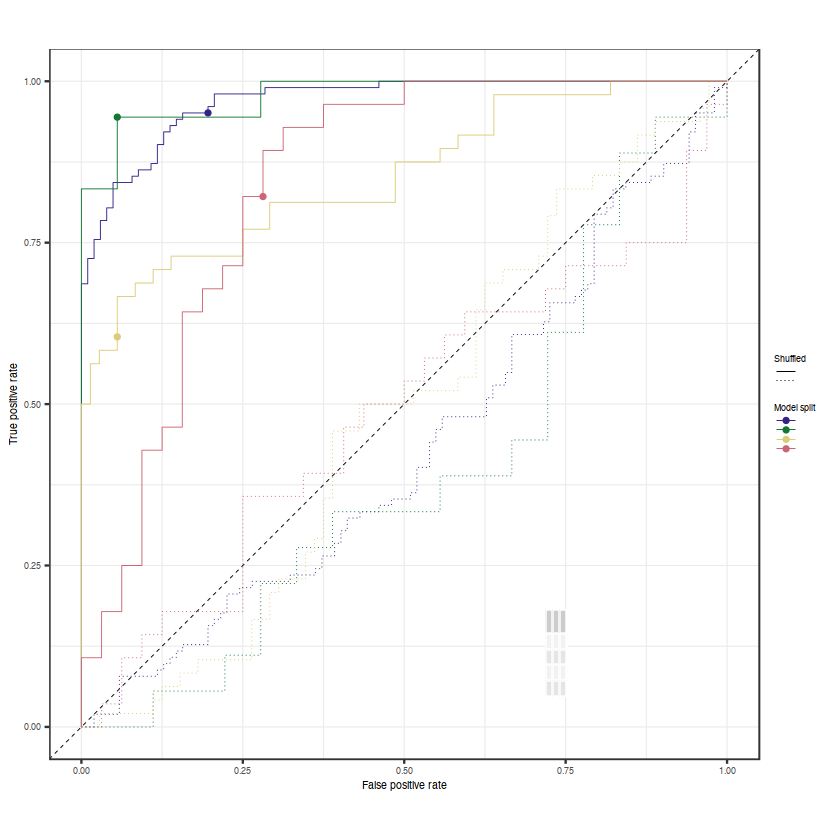

In [8]:
threshold_points_df <- roc_curve_df %>%
    dplyr::filter(shuffled == "False") %>%
    dplyr::group_by(model_split) %>%
    dplyr::filter(abs(threshold) == min(abs(threshold))) %>%
    dplyr::ungroup()

roc_curve_df$model_split <- factor(
    roc_curve_df$model_split,
    levels = c("training", "validation", "test", "holdout")
)

roc_gg <- (
    ggplot(roc_curve_df, aes(x = fpr, y = tpr))
    + geom_line(aes(color = model_split, linetype = shuffled), size=0.2)
    + geom_point(data = threshold_points_df, aes(color = model_split), size = 1)
    + geom_abline(intercept=0, slope=1, size=0.2, linetype="dashed", color="black")
    + scale_color_manual(name="Model split", labels=legend_labels, values=legend_colors)
    + scale_linetype_manual(name="Shuffled", labels=linetype_labels, values=linetype_default)
    + coord_fixed()
    + xlab("False positive rate")
    + ylab("True positive rate")
    + annotation_custom(table_gg, ymin = -0.82, xmin = 0.42)
    + custom_theme
)

output_fig_file <- file.path("figures", "bortezomib_roc_curve.png")
ggsave(output_fig_file, roc_gg, dpi = 500, height = 2.5, width = 3)

roc_gg

## Plot signature scores

In [9]:
table(signature_df$Metadata_model_split)


   holdout       test   training validation 
        60        120        204         36 

In [10]:
main_clones_signature_df <- signature_df %>%
    dplyr::filter(Metadata_clone_number %in% main_clones)

main_clones_signature_df$Metadata_model_split <- factor(
    main_clones_signature_df$Metadata_model_split,
    levels = rev(main_model_splits)
)

main_clones_signature_df$Metadata_clone_type <- factor(
    main_clones_signature_df$Metadata_clone_type,
    levels = c("sensitive", "resistant")
)

min_val <- unique(main_clones_signature_df$min_permuted_value)
max_val <- unique(main_clones_signature_df$max_permuted_value)

In [11]:
# For a consistent custom theme
custom_theme <- ggplot2::theme_bw() + ggplot2::theme(
    legend.title = element_text(size = 5),
    legend.text = element_text(size = 4),
    axis.title = element_text(size = 6),
    axis.text = element_text(size = 5),
    strip.text = element_text(size = 5, margin = margin(0.8, 1, 0.8, 1, "mm")),
    strip.background = element_rect(colour = "black", fill = "#fdfff4"),
    legend.key.size = unit(2, "mm"),
    legend.key.width = unit(5, "mm"),
    legend.margin = margin(l = -2),
    panel.grid.major = element_line(size = 0.25),
    panel.grid.minor = element_line(size = 0.25)
)

In [12]:
random_perm_legend <- (
    ggplot(
        main_clones_signature_df %>% dplyr::mutate(label="grey"),
        aes(x=Metadata_clone_number, y = TotalScore, color = label)
    )
    + geom_line(linetype = "dashed", lwd = 0.1)
    + scale_color_manual(
        name = "",
        values = "red",
        labels = "95% CI\n1000 random\npermutations"
    )
    + custom_theme
    + theme(legend.key = element_rect(fill = alpha("grey", 0.2)))
)

random_perm_legend <- cowplot::get_legend(random_perm_legend)

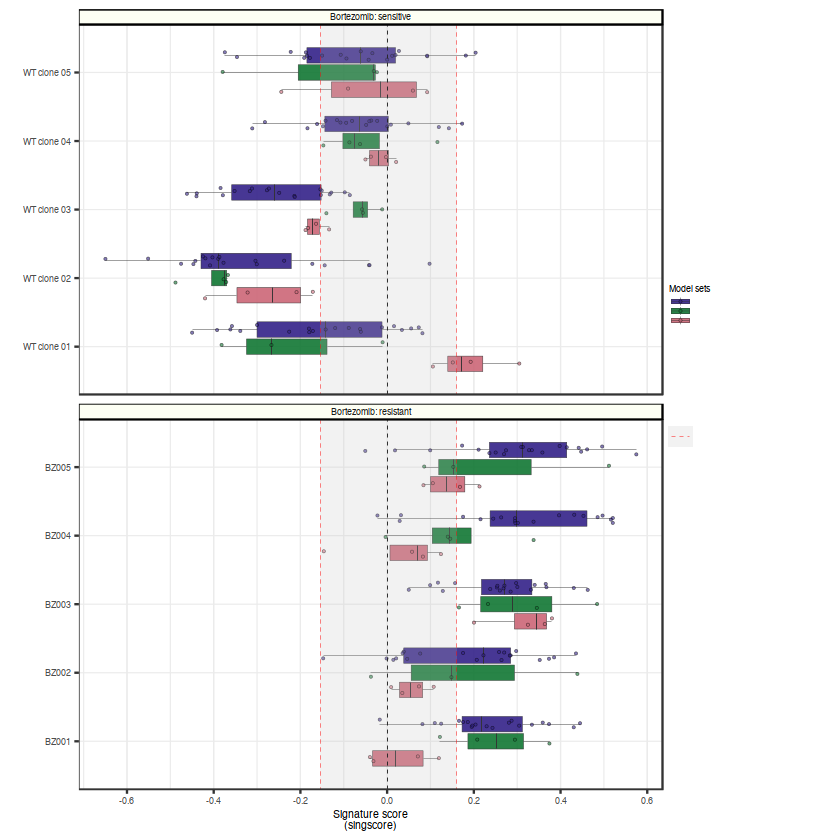

In [13]:
append_sig <- function(string) paste0(stringr::str_to_title(dataset), ": ", string)

box_plot_gg <- (
    ggplot(main_clones_signature_df, aes(x = Metadata_clone_number, y = TotalScore))
    + geom_boxplot(aes(fill = Metadata_model_split), lwd = 0.1, alpha = 0.9, outlier.alpha = 0)
    + geom_jitter(
        position = position_jitterdodge(jitter.width = 0.4, dodge.width = 0.75),
        aes(fill = Metadata_model_split),
        stroke = 0.2,
        alpha = 0.6,
        shape = 21,
        lwd = 0.5
    )
    + facet_wrap("~Metadata_clone_type",
               ncol = 1,
               scales = "free_y",
               labeller = labeller(Metadata_clone_type = as_labeller(append_sig)))
    + xlab("")
    + ylab("Signature score\n(singscore)")
    + scale_fill_manual("Model sets", values = legend_colors, labels = legend_labels)
    + scale_y_continuous(breaks = c(-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6), minor_breaks = seq(-10, 10, 0.1))
    + geom_hline(yintercept = 0, linetype = "dashed", size = 0.2, color = "black")
    + coord_flip()
    + annotate(
        "rect",
         ymin = min_val,
         ymax = max_val,
         xmin = 0.3,
         xmax = ceiling(length(main_clones) / 2) + 0.7,
         alpha = 0.2,
         color = "red",
         linetype = "dashed",
         fill = "grey",
         size = 0.1
    )
    + custom_theme
    + guides(fill = guide_legend(reverse = TRUE))
) 

boxplot_legend <- cowplot::plot_grid(
    cowplot::ggdraw(),
    cowplot::get_legend(box_plot_gg),
    cowplot::ggdraw(),
    random_perm_legend,
    cowplot::ggdraw(),
    nrow = 5,
    rel_heights = c(0.7, 0.35, 0.01, 0.35, 1),
    align = "hv",
    axis = "l"
)

box_plot_gg <- cowplot::plot_grid(
    box_plot_gg + theme(legend.position = "none"),
    boxplot_legend,
    ncol = 2,
    align = "h",
    axis = "l",
    rel_widths = c(1, 0.25),
    labels = c("", "")
)


output_fig_file <- file.path("figures", "bortezomib_signature_scores_main_clones.png")
ggsave(output_fig_file, box_plot_gg, dpi = 500, height = 2.5, width = 3)

box_plot_gg

## Plot ground truth signature scores

In [14]:
test_signature_df <- signature_df %>%
    dplyr::filter(Metadata_model_split == "test")

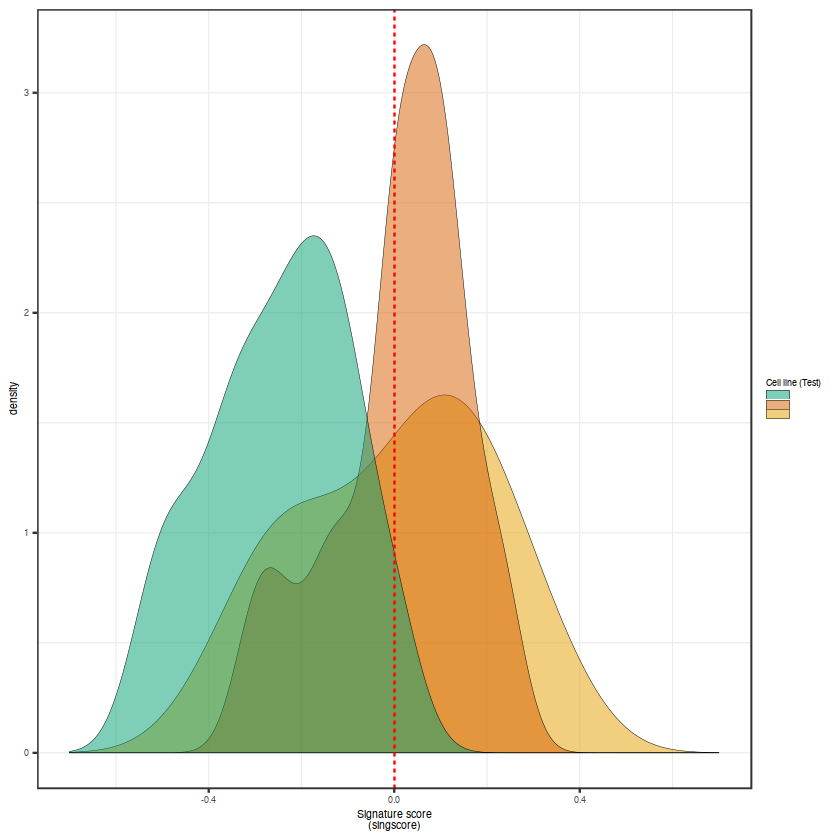

In [15]:
density_gg <- (
    ggplot(test_signature_df, aes(x=TotalScore, fill=Metadata_clone_number))
    + geom_density(alpha = 0.5, lwd = 0.1)
    + custom_theme
    + xlim(-0.7, 0.7)
    + geom_vline(xintercept=0, linetype="dashed", color="red")
    + xlab("Signature score\n(singscore)")
    + scale_fill_manual(name = "Cell line (Test)", labels = clone_labels, values = clone_colors)
    + guides(fill = guide_legend(reverse = TRUE))
)

output_fig_file <- file.path("figures", "bortezomib_signature_scores_test_clones.png")
ggsave(output_fig_file, density_gg, dpi = 500, height = 2.5, width = 3)

density_gg

## Visualize other performance metrics

* Accuracy
* Average precision

In [16]:
perf_dir <- file.path("results", "performance")

metric_levels <- c("total", "plate", "sample")
shuffle_levels <- c("", "shuffle")

performance_data <- list()
for (metric_level in metric_levels) {
    performance_data[[metric_level]] <- list()
    for (shuffle_level in shuffle_levels) {
        if (shuffle_level == "shuffle") {
            shuffle_id <- "_shuffle"
        } else {
            shuffle_id <- ""
        }
        
        input_file <- paste0(metric_level, "_bortezomib", shuffle_id, "_metric_performance.tsv")
        input_file <- file.path(perf_dir, input_file)
        performance_data[[metric_level]][[shuffle_level]] <-
            readr::read_tsv(input_file, col_types = readr::cols())
    }
}

In [17]:
total_performance_df <- dplyr::bind_rows(performance_data[["total"]])
plate_performance_df <- dplyr::bind_rows(performance_data[["plate"]])

In [18]:
shuffle_conf_int_df <- total_performance_df %>%
    dplyr::filter(shuffle == "True") %>%
    tidyr::drop_na() %>%
    dplyr::group_by(Metadata_model_split, metric, dataset) %>%
    dplyr::mutate(
        low_conf = quantile(metric_value, 0.05),
        high_conf = quantile(metric_value, 0.95),
        median_val = median(metric_value)
    )  %>%
    dplyr::distinct(Metadata_model_split, metric, dataset, low_conf, median_val, high_conf)

real_perf_df <- total_performance_df %>%
    dplyr::filter(shuffle == "False") %>%
    dplyr::distinct(Metadata_model_split, metric_value, metric, dataset)

In [19]:
performance_summary_df <- real_perf_df %>%
    dplyr::left_join(
        shuffle_conf_int_df,
        by = c("Metadata_model_split", "metric", "dataset")
    ) %>%
    dplyr::filter(Metadata_model_split %in% !!main_model_splits)

performance_summary_df$Metadata_model_split <- factor(
    performance_summary_df$Metadata_model_split,
    levels = main_model_splits
)

metric_recode <- c("accuracy" = "Accuracy", "avg_precision" = "Avg. precision")
performance_summary_df$metric <- dplyr::recode(performance_summary_df$metric, !!!metric_recode)

performance_summary_df

Metadata_model_split,metric_value,metric,dataset,low_conf,median_val,high_conf
<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
holdout,0.7833333,Accuracy,bortezomib,0.4000000,0.5000000,0.5850000
test,0.8000000,Accuracy,bortezomib,0.4329167,0.5000000,0.5750000
training,0.8774510,Accuracy,bortezomib,0.4313725,0.5000000,0.5588235
validation,0.9166667,Accuracy,bortezomib,0.3611111,0.5000000,0.6388889
holdout,0.6927803,Avg. precision,bortezomib,0.4279228,0.4650150,0.5175031
test,0.6770833,Avg. precision,bortezomib,0.3704705,0.3967262,0.4390168
training,0.8129294,Avg. precision,bortezomib,0.4707968,0.5000000,0.5328088
validation,0.8921569,Avg. precision,bortezomib,0.4470899,0.5000000,0.5845411


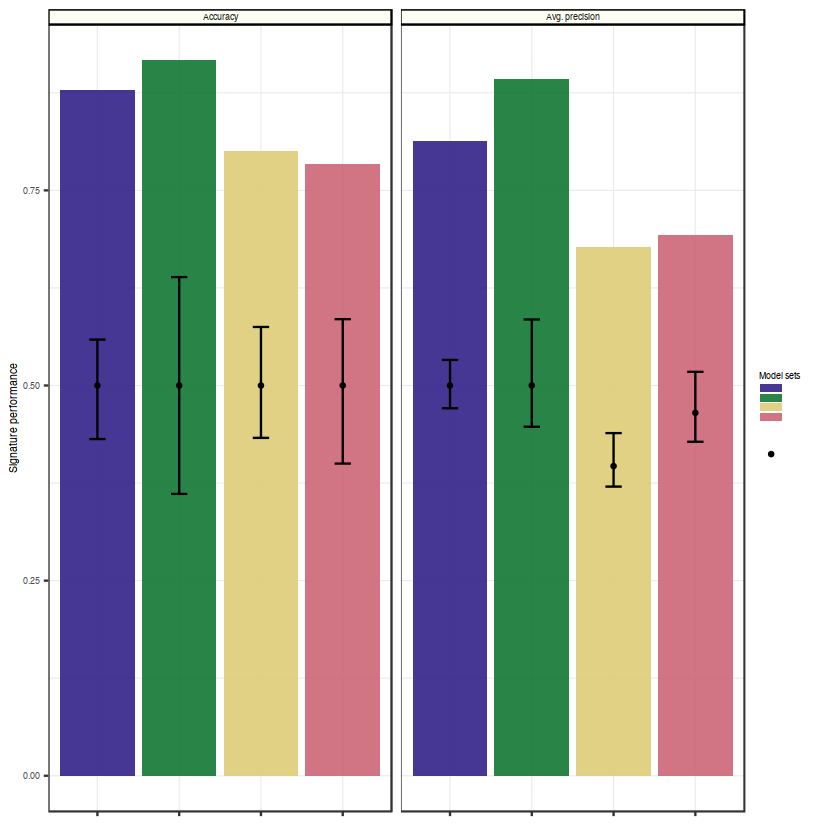

In [20]:
bar_chart_gg <- (
    ggplot(
        performance_summary_df,
        aes(
            x = Metadata_model_split, 
            y = metric_value,
            fill = Metadata_model_split
        )
    )
    + geom_bar(stat = "identity", alpha = 0.9)
    + geom_errorbar(aes(ymin = low_conf, ymax = high_conf), width = 0.2, lwd = 0.5)
    + geom_point(aes(y = median_val, color = "median_val"), size = 0.8)
    + facet_wrap("~metric")
    + scale_fill_manual("Model sets", values = legend_colors, labels = legend_labels)
    + scale_color_manual(name = NULL, values = c("median_val" = "black"), labels = c("median_val" = "Median\npermutated\n(+/- 95% conf)"))
    + custom_theme
    + theme(axis.text.x = element_blank())
    + xlab("")
    + ylab("Signature performance")
    + guides(fill = guide_legend(order = 1, reverse = FALSE, override.aes = list(shape = NA)))
)

output_fig_file <- file.path("figures", "bortezomib_performance_metrics_bar.png")
ggsave(output_fig_file, bar_chart_gg, dpi = 500, height = 2.5, width = 3)

bar_chart_gg

In [21]:
shuffle_conf_int_df <- plate_performance_df %>%
    dplyr::filter(shuffle == "True") %>%
    tidyr::drop_na() %>%
    dplyr::group_by(Metadata_model_split, Metadata_Plate, metric, dataset) %>%
    dplyr::mutate(
        low_conf = quantile(metric_value, 0.05),
        high_conf = quantile(metric_value, 0.95),
        median_val = median(metric_value)
    )  %>%
    dplyr::distinct(Metadata_model_split, Metadata_Plate, metric, dataset, low_conf, median_val, high_conf)

real_perf_df <- plate_performance_df %>%
    dplyr::filter(shuffle == "False") %>%
    dplyr::distinct(Metadata_model_split, Metadata_Plate, metric_value, metric, dataset)

performance_summary_df <- real_perf_df %>%
    dplyr::left_join(
        shuffle_conf_int_df,
        by = c("Metadata_model_split", "Metadata_Plate", "metric", "dataset")
    ) %>%
    dplyr::filter(Metadata_model_split %in% !!main_model_splits)

performance_summary_df$Metadata_model_split <- factor(
    performance_summary_df$Metadata_model_split,
    levels = main_model_splits
)

metric_recode <- c("accuracy" = "Accuracy", "avg_precision" = "Avg. precision")
performance_summary_df$metric <- dplyr::recode(performance_summary_df$metric, !!!metric_recode)

# Add batch information
performance_summary_df <- performance_summary_df %>%
    dplyr::left_join(
        signature_df %>% dplyr::distinct(Metadata_Plate, Metadata_batch),
        by = "Metadata_Plate"
    )

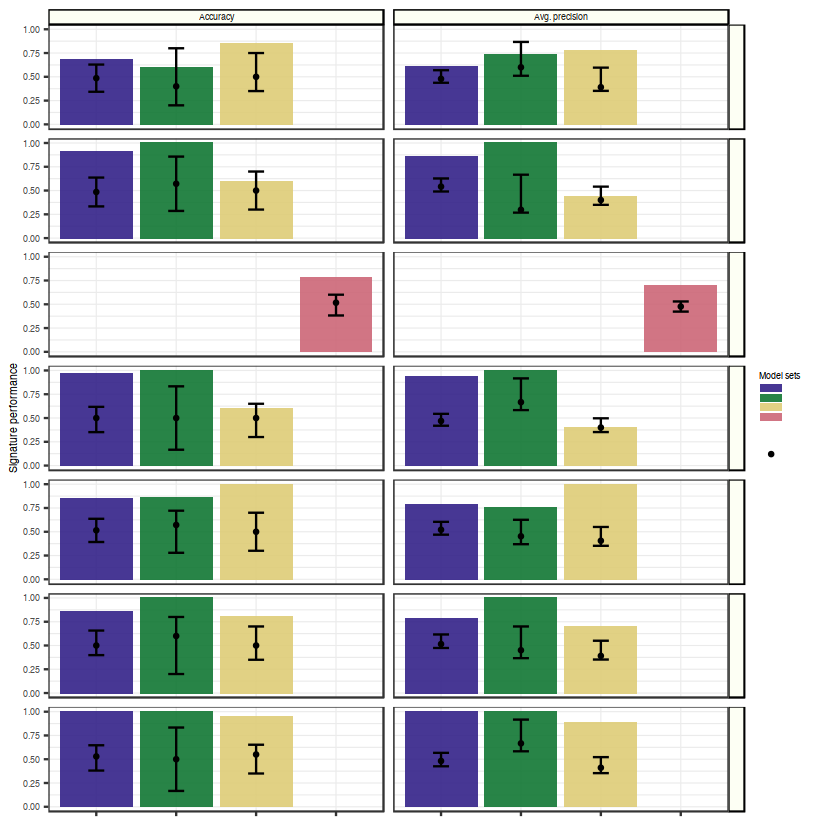

In [22]:
bar_chart_gg <- (
    ggplot(
        performance_summary_df,
        aes(
            x = Metadata_model_split, 
            y = metric_value,
            fill = Metadata_model_split
        )
    )
    + geom_bar(stat="identity", alpha = 0.9)
    + geom_errorbar(aes(ymin = low_conf, ymax = high_conf), width = 0.2, lwd = 0.5)
    + geom_point(aes(y = median_val, color = "median_val"), size = 0.8)
    + facet_grid("Metadata_batch~metric")
    + scale_fill_manual("Model sets", values = legend_colors, labels = legend_labels)
    + scale_color_manual(
        name = NULL,
        values = c("median_val" = "black"),
        labels = c("median_val" = "Median\npermutated\n(+/- 95% conf)")
    )
    + custom_theme
    + theme(axis.text.x = element_blank(), strip.text.y = element_text(size = 4))
    + xlab("")
    + ylab("Signature performance")
    + guides(fill = guide_legend(order = 1, reverse = FALSE, override.aes = list(shape = NA)))
)

output_fig_file <- file.path("figures", "bortezomib_performance_metrics_bar_byplate.png")
ggsave(output_fig_file, bar_chart_gg, dpi = 500, height = 5, width = 3)

bar_chart_gg